In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm


In [2]:
RANDOM_SEED     = 42
BATCH_SIZE      = 512
NUM_EPOCHS      = 40
LEARNING_RATE   = 1e-4
NUM_CLASSES     = 10
PATCH_SIZE      = 4
IMG_SIZE        = 28
IN_CHANNELS     = 3
NUM_HEADS       = 4
DROPOUT         = 0.001
HIDDEN_DIM      = 768
ACTIVATION      = "gelu"
NUM_ENCODERS    = 4
EMBEDDING_DIM   = (PATCH_SIZE ** 2) * IN_CHANNELS -((PATCH_SIZE ** 2) * IN_CHANNELS)%NUM_HEADS
NUM_PATCHES     = (IMG_SIZE // PATCH_SIZE) ** 2
ADAM_WEIGHT_DECAY   = 0
ADAM_BETAS          = 0.9, 0.999

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from skimage import io
import albumentations as A

def get_image(img_path,size=IMG_SIZE):
    """
    Load an image, normalize it, and resize it.

    Args:
        img_path (str): Path to the image file.
        size (int, optional): Desired size for the output image. Defaults to IMG_SIZE.

    Returns:
        tuple: A tuple containing:
            - img (torch.Tensor): The processed image tensor with shape (1, 3, size, size).
            - norm_img (numpy.ndarray): The normalized image array.
            - org_img (numpy.ndarray): The original image array.
    """
    img = io.imread(img_path)
    org_img = img.copy()

    img = A.Normalize()(image=img)['image']
    norm_img = img.copy()

    img = np.transpose(img, (2, 0, 1)) # HWC to CHW
    img = np.expand_dims(img, axis=0) # add batch dimension

    img = torch.tensor(img, dtype=torch.float32)
    img = nn.Upsample(size=(size, size),mode='bilinear')(img)

    return img, norm_img, org_img

img_path = "/home/vip/salman_workspace/projects/Project_31_vitreg/dinov2/mug.jpeg"

img, norm_img, org_img = get_image(img_path)

In [4]:
class PatchEmbedding(nn.Module):
    """
    Patch Embedding layer for Vision Transformer with additional register tokens.

    Methods:
        forward(x): Forward pass to generate patch embeddings with class and register tokens.
    """
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        """
        Initializes the custom module with the given parameters.
        Args:
            embed_dim (int): The dimension of the embedding space.
            patch_size (int): The size of each patch.
            num_patches (int): The number of patches.
            dropout (float): The dropout rate.
            in_channels (int): The number of input channels.
        Attributes:
            patcher (nn.Sequential): A sequential container that includes a Conv2d layer, a Dropout layer, and a Flatten layer.
            cls_token (nn.Parameter): A learnable parameter representing the class token.
            register_tokens (nn.Parameter): A learnable parameter representing the register tokens.
            pos_embedding (nn.Parameter): A learnable parameter representing the positional embeddings.
            dropout (nn.Dropout): A dropout layer.
        """
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Dropout(dropout),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.register_tokens = nn.Parameter(torch.randn(1, 4, embed_dim), requires_grad=True)  # 4 register tokens
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 5, embed_dim), requires_grad=True)  # +1(cls) + 4(registers)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Perform the forward pass of the model.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).
        Returns:
            torch.Tensor: Output tensor after applying patch embedding, concatenation with 
                          class and register tokens, positional embedding, and dropout.
        """
        batch_size = x.shape[0]
        
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        register_tokens = self.register_tokens.expand(batch_size, -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_tokens, register_tokens, x], dim=1)  # concatenate cls and register tokens with patches
        x += self.pos_embedding
        x = self.dropout(x)
        
        return x


In [5]:
class Attention(nn.Module):
    """
    Attention mechanism for transformer models.
    Attributes:
        num_heads (int): Number of attention heads.
        scale (float): Scaling factor for attention scores.
        qkv (nn.Linear): Linear layer to project input to query, key, and value.
        q_norm (nn.Module): Normalization layer for query.
        k_norm (nn.Module): Normalization layer for key.
        attn_drop (nn.Dropout): Dropout layer for attention weights.
        proj (nn.Linear): Linear layer for output projection.
        proj_drop (nn.Dropout): Dropout layer for output projection.
    """
    def __init__(self, dim, num_heads, qkv_bias=False, attn_drop=0., proj_drop=0.):
        """
        Initializes the custom attention module.

        Args:
            dim (int): The dimensionality of the input and output features.
            num_heads (int): The number of attention heads.
            qkv_bias (bool, optional): If True, adds a learnable bias to the query, key, and value projections. Default is False.
            attn_drop (float, optional): Dropout rate for the attention weights. Default is 0.
            proj_drop (float, optional): Dropout rate for the output projection. Default is 0.

        Raises:
            AssertionError: If `dim` is not divisible by `num_heads`.
        """
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'

        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.q_norm = nn.Identity()  # Can be replaced with nn.LayerNorm or other normalization
        self.k_norm = nn.Identity()  # Can be replaced with nn.LayerNorm or other normalization
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        """
        Perform the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (B, N, C) where B is the batch size, 
                              N is the sequence length, and C is the number of channels.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing:
                - Output tensor of shape (B, N, C) after applying attention and projection.
                - Attention weights tensor of shape (B, num_heads, N, N).
        """
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        q = self.q_norm(q)
        k = self.k_norm(k)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

class GluMlp(nn.Module):
    """
    A Gated Linear Unit (GLU) based Multi-Layer Perceptron (MLP) module.

    Attributes:
        fc1 (nn.Linear): The first fully connected layer.
        act (nn.SiLU): The activation function (SiLU).
        drop1 (nn.Dropout): The dropout layer after the activation function.
        norm (nn.Identity): An identity normalization layer.
        fc2 (nn.Linear): The second fully connected layer.
        drop2 (nn.Dropout): The dropout layer after the second fully connected layer.
    """
    def __init__(self, embed_dim, hidden_dim, dropout=0.0):
        """
        Initialize the custom neural network module.

        Args:
            embed_dim (int): The dimension of the input embeddings.
            hidden_dim (int): The dimension of the hidden layer.
            dropout (float, optional): The dropout rate to be applied after the activation functions. Default is 0.0.

        Attributes:
            fc1 (nn.Linear): The first fully connected layer.
            act (nn.SiLU): The activation function (SiLU).
            drop1 (nn.Dropout): The dropout layer applied after the first activation function.
            norm (nn.Identity): An identity layer (no operation).
            fc2 (nn.Linear): The second fully connected layer.
            drop2 (nn.Dropout): The dropout layer applied after the second fully connected layer.
        """
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim, bias=True)
        self.act = nn.SiLU()
        self.drop1 = nn.Dropout(dropout)
        self.norm = nn.Identity()
        self.fc2 = nn.Linear(hidden_dim, embed_dim, bias=True)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of the neural network layer.

        Args:
            x (torch.Tensor): Input tensor to the layer.

        Returns:
            torch.Tensor: Output tensor after applying the layer transformations.
        """
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

class LayerScale(nn.Module):
    """
    A custom PyTorch layer that scales the input tensor by a learnable parameter.

    Attributes:
        scale (torch.nn.Parameter): A learnable parameter that scales the input tensor.
    """
    def __init__(self, scale_init=1e-4):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1) * scale_init)

    def forward(self, x):
        return self.scale * x

class Block(nn.Module):
    """
    A Transformer block consisting of a self-attention mechanism followed by a feed-forward neural network.
    
    Attributes:
        norm1 (nn.LayerNorm): Layer normalization applied before the attention mechanism.
        attn (Attention): Multi-head self-attention mechanism.
        ls1 (LayerScale): Layer scaling applied after the attention mechanism.
        drop_path1 (nn.Identity): Identity layer for potential drop path.
        norm2 (nn.LayerNorm): Layer normalization applied before the feed-forward network.
        mlp (GluMlp): Feed-forward network with Gated Linear Units.
        ls2 (LayerScale): Layer scaling applied after the feed-forward network.
        drop_path2 (nn.Identity): Identity layer for potential drop path.
    """
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = Attention(dim=embed_dim, num_heads=num_heads, attn_drop=dropout)
        self.ls1 = LayerScale()
        self.drop_path1 = nn.Identity()
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = GluMlp(embed_dim, hidden_dim, dropout)
        self.ls2 = LayerScale()
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        # Attention block
        x_res = x
        x = self.norm1(x)
        x, _ = self.attn(x)
        x = self.ls1(x_res + x)
        
        # MLP block
        x_res = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.ls2(x_res + x)
        
        return x

class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model.

    Attributes:
        patch_embed (PatchEmbedding): Embedding layer for patches.
        pos_drop (nn.Dropout): Dropout layer for positional embeddings.
        patch_drop (nn.Identity): Identity layer for patch dropout (no dropout).
        norm_pre (nn.Identity): Identity layer for pre-normalization (no normalization).
        blocks (nn.Sequential): Sequential container of encoder layers (Block).
        head (nn.Linear): Linear layer for classification.
    """
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        """
        Initialize the custom Vision Transformer model.
        Args:
            num_patches (int): Number of patches to divide the image into.
            img_size (int): Size of the input image.
            num_classes (int): Number of output classes for classification.
            patch_size (int): Size of each patch.
            embed_dim (int): Dimension of the embedding.
            num_encoders (int): Number of encoder layers.
            num_heads (int): Number of attention heads in each encoder layer.
            hidden_dim (int): Dimension of the hidden layer in the feed-forward network.
            dropout (float): Dropout rate.
            activation (str): Activation function to use.
            in_channels (int): Number of input channels in the image.
        """
        super().__init__()
        self.patch_embed = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        self.pos_drop = nn.Dropout(0.0)  # No position dropout
        self.patch_drop = nn.Identity()  # No patch dropout
        self.norm_pre = nn.Identity()  # Pre-normalization is Identity
        
        # The blocks are sequentially stacked encoder layers (Block)
        self.blocks = nn.Sequential(
            *[Block(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_encoders)]
        )
        
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)
        x = self.patch_drop(x)
        x = self.norm_pre(x)
        
        # Pass through all blocks
        for blk in self.blocks:
            x = blk(x)
        
        x = self.head(x[:, 0])  # Use the CLS token for classification
        return x


In [6]:
model = VisionTransformer(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBEDDING_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)

In [7]:
train_df = pd.read_csv("./dataset/train.csv")
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED)

In [8]:
class MNISTTrainDataset3C(Dataset):
    """
    A custom dataset class for MNIST training data with 3-channel RGB images.
   
    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary with image, label, and index for the given index.
    Returns:
        dict: A dictionary containing:
            - "image" (torch.Tensor): Transformed 3-channel image.
            - "label" (int): Corresponding label.
            - "index" (int): Corresponding index.
    """
    def __init__(self, images, labels, indicies, transformed=False):
        """
        Initialize the custom dataset.

        Args:
            images (list or numpy.ndarray): List or array of images.
            labels (list or numpy.ndarray): List or array of labels corresponding to the images.
            indicies (list or numpy.ndarray): List or array of indices for the dataset.
            transformed (bool, optional): If True, apply random rotation to the images. Default is False.
        """
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        if transformed:
           self.transform.transforms.insert(1, transforms.RandomRotation(15))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Reshape and convert to uint8
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]

        # Convert the single channel to 3 channels (RGB)
        image = np.stack([image] * 3, axis=-1)  # Stack the same image 3 times for RGB
        
        # Apply transformations
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}

In [9]:
train_dataset = MNISTTrainDataset3C(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values, transformed=True)
val_dataset = MNISTTrainDataset3C(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values, transformed=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Val Image')

<Figure size 432x288 with 0 Axes>

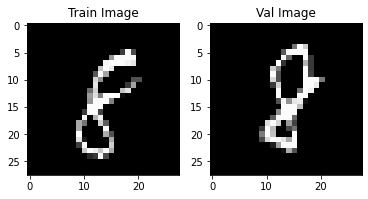

In [10]:
plt.figure()
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(train_dataset[0]["image"].permute(1, 2, 0).squeeze(),cmap='gray')
axarr[0].set_title("Train Image")

axarr[1].imshow(val_dataset[0]["image"].permute(1, 2, 0).squeeze(),cmap='gray')
axarr[1].set_title("Val Image")

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
outputs = {}
def get_outputs(name):
    """
    Returns a hook function to capture the output of a specific layer in a model.
    Args:
        name (str): The name to associate with the captured output.
    Returns:
        function: A hook function that captures the output of the specified layer.
    """
    def hook(model, input, output):
        outputs[name] = output.detach()
        
    return hook

In [13]:
# Get the scale value from the last attention block
scale = model.blocks[-1].attn.scale

# Register forward hooks to capture the outputs of q_norm, k_norm, and features from the last attention block
model.blocks[-1].attn.q_norm.register_forward_hook(get_outputs('q_norm'))
model.blocks[-1].attn.k_norm.register_forward_hook(get_outputs('k_norm'))
model.blocks[-1].register_forward_hook(get_outputs('features'))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred= model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred= model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")

In [15]:
torch.cuda.empty_cache()

In [16]:
model.eval()
selected = img[7]

with torch.no_grad():
    out = model(selected.unsqueeze(0).cuda())
    print(out.shape)
    print(torch.argmax(out,dim=-1))
outputs["attention"] = (outputs["q_norm"] @ outputs["k_norm"].transpose(-2, -1)) * scale
outputs["attention"] = outputs["attention"].softmax(dim=-1)

torch.Size([1, 10])
tensor([7], device='cuda:0')


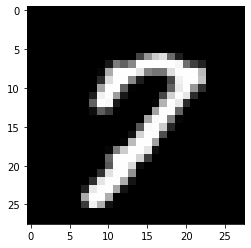

In [17]:
image = selected.cpu().numpy().transpose(1, 2, 0)  # Convert to (28, 28, 3) format for plotting
image = (image * 0.5) + 0.5

# Plot the image
plt.imshow(image)
plt.show()

/home/vip/anaconda3/envs/env_torch/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


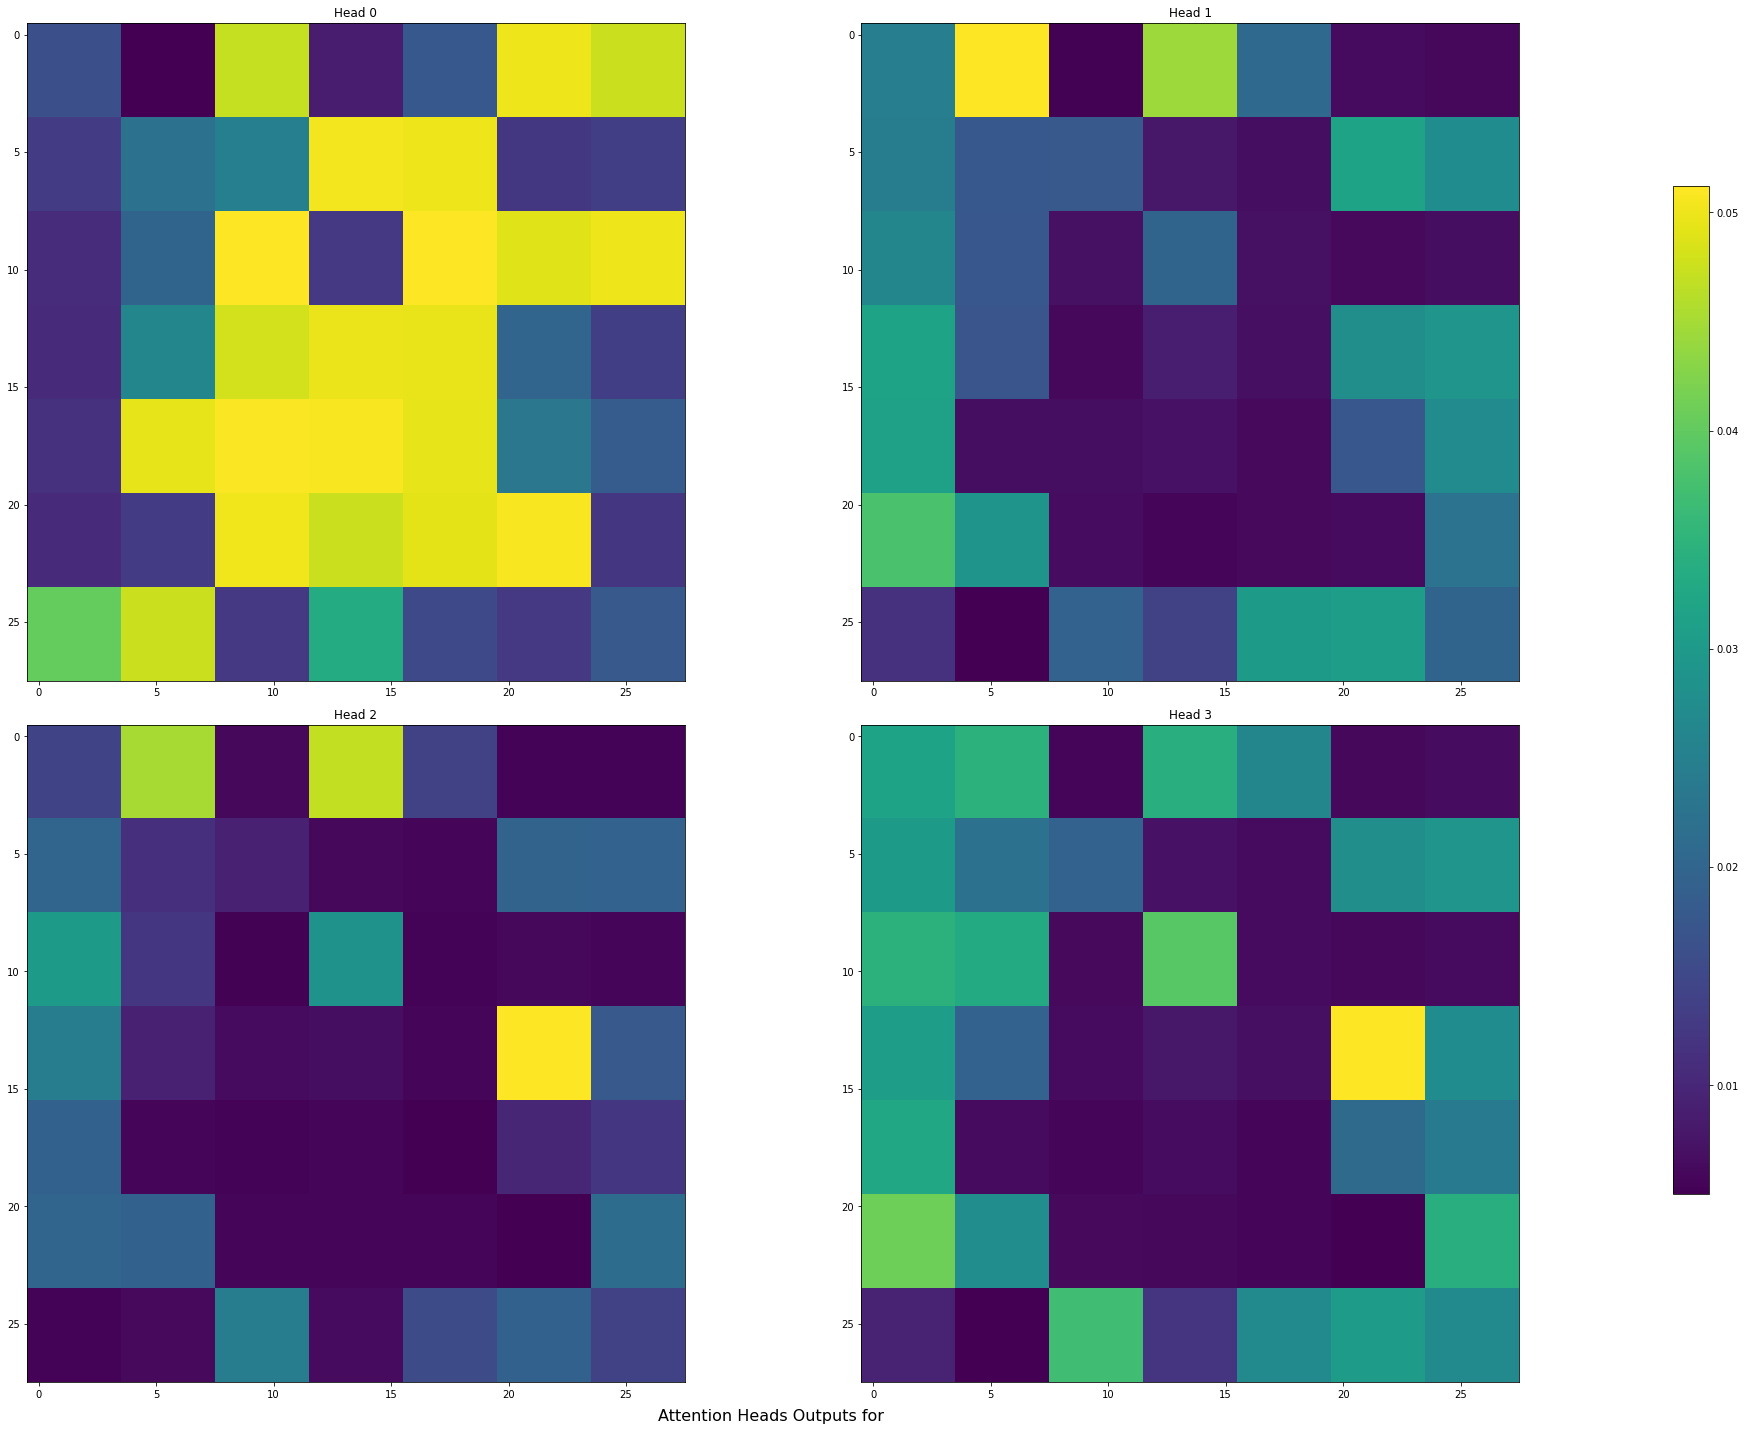

In [18]:
# Get the shape of the attention output
b, num_heads, num_patches_1, num_patches_1 = outputs["attention"].shape

# Define image size and calculate the number of patches excluding the class and register tokens
img_size = 28
num_patches_1 = num_patches_1 - 5  # -1 for cls token, -4 for registers
map_size = int(np.sqrt(num_patches_1))

# Define the number of plots and the layout of the subplots
num_plots = num_heads
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(25, 20))
axes = axes.flatten()

# Iterate over each attention head and plot the attention map
for i in range(num_plots):
    attention_head = i
    attention_map = outputs["attention"][:, attention_head, 0, 5:]  # Exclude cls and register tokens
    attention_map = attention_map.view(1, 1, map_size, map_size)
    attention_map = nn.Upsample(size=(img_size, img_size))(attention_map)
    attention_map = attention_map[0, 0, :, :].detach().cpu().numpy()

    im = axes[i].imshow(attention_map)
    axes[i].set_title(f'Head {attention_head}')

# Adjust the layout and add a colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

# Set the main title and show the plot
fig.suptitle('Attention Heads Outputs for ', y=0.001, fontsize=16)
plt.tight_layout()
plt.show()